In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import yfinance as yf

from arch.compat.numba import jit

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from enum import Enum
import math

In [3]:
class BetaType(Enum):
    NO = 1
    RAW = 2
    RETURNS = 3
    FILTERED = 4

In [4]:
DATE_FROM = '2015-01-01'
DATE_TO = '2017-12-31'
tickers = ['ARE', 'CTL', 'ALD', 'AAP', 'MMM',
           'ABMD', 'TSLA', 'APD', 'ATO', 'AMZN']

INITIAL_CASH = 500000
FEE = 0.001
MAX_POSITION_PER_EQUITY = max(1. / len(tickers), 0.2)
MAX_POSITION_PER_EQUITY_PER_TRADE = max(1. / len(tickers), 0.05)
MAX_DRAWDOWN_PER_DAY = 0.005
MAX_DRAWDOWN_PER_WEEK = 0.02

In [5]:
BETA_TYPE = BetaType.FILTERED
BETA_LAG = 252
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 200
GARCH_REFIT_DELAY_DAYS = 30

In [6]:
MEAN_MODEL = "Constant"
VOL_MODEL = "Garch"
DISTRIBUTION_ = "Normal"

In [7]:
p_ = 2
o_ = 0
q_ = 2

In [8]:

def _find_best_model_params(TS: pd.Series):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1, 5) # [1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order

In [9]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [10]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to)
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [11]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().fillna(0)

In [12]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    return market.cov(single_stock, lag) / market.var(ddof=lag)

In [13]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean,
                       lags=lag,
                       vol=vol, 
                       p=p, o=o, q=q,
                       dist=dist)

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0]) / scaling_const
    varis = pd.Series(forecast.variance.tail(1).to_numpy()[0]) / (scaling_const ** 2)
    return stand_residuals, means, varis

In [14]:
@jit
def get_filtered_data(nmkt_rets_df):
    net_market_returns_f = {}
    means = {}
    varis = {}
    for ticker, net_rets in nmkt_rets_df.iteritems():
        fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                              p=p_, o=o_, q=q_)
        net_market_returns_f[ticker] = fltr_res[GARCH_LAG:]
        means[ticker] = fcst_means
        varis[ticker] = fcst_vars

    nmkt_retsf_df = pd.DataFrame(net_market_returns_f, columns=tickers)
    means_df = pd.DataFrame(means, columns=tickers)
    vars_df = pd.DataFrame(varis, columns=tickers)
    return (nmkt_retsf_df, means_df, vars_df)

In [15]:
def remove_row_and_column(matrix: np.array, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [16]:
def calc_alphas(real_returns: pd.DataFrame, corr_matrix: pd.DataFrame, means: pd.DataFrame, varis: pd.DataFrame):
    alphas = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        r_j_j = remove_row_and_column(corr_matrix.to_numpy(), i)
        inv_r_j_j = np.linalg.inv(r_j_j)
        mu_j = np.delete(means.to_numpy(), i)
        sigma_j = np.delete(varis.to_numpy(), i)
        rets = np.delete(real_returns.to_numpy(), i)
        v = (rets - mu_j) / sigma_j
        corr_v = np.delete(corr_matrix[ticker].to_numpy(), i)
        mu = means[ticker] + varis[ticker] * corr_v.dot(inv_r_j_j).dot(v)
        alphas[ticker] = alpha(mu, real_returns[ticker])
    return pd.DataFrame(alphas, columns=tickers, index=[0])

In [17]:
def alpha(mu, real_return):
    return 2 * mu - real_return



In [18]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = {}
for ticker in tickers:
    raw_prices[ticker] = raw_adj_close_prices(ticker, DATE_FROM, DATE_TO)
rp_df = pd.DataFrame(raw_prices, columns=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
rp_df.tail(1)

,ARE,CTL,ALD,AAP,MMM,ABMD,TSLA,APD,ATO,AMZN
Date,,,,,,,,,,
2017-12-29,121.550194,12.776215,44.603436,98.587479,215.700958,187.410004,62.27,154.349213,80.948784,1169.469971


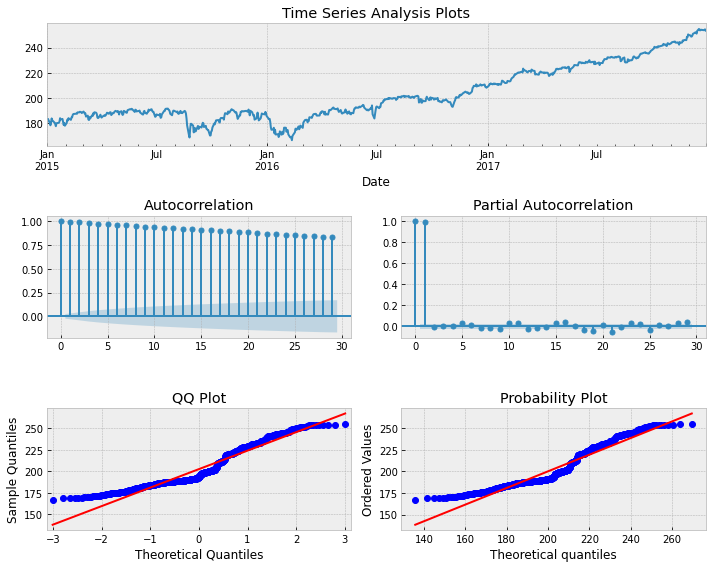

In [20]:
tsplot(spy_p)

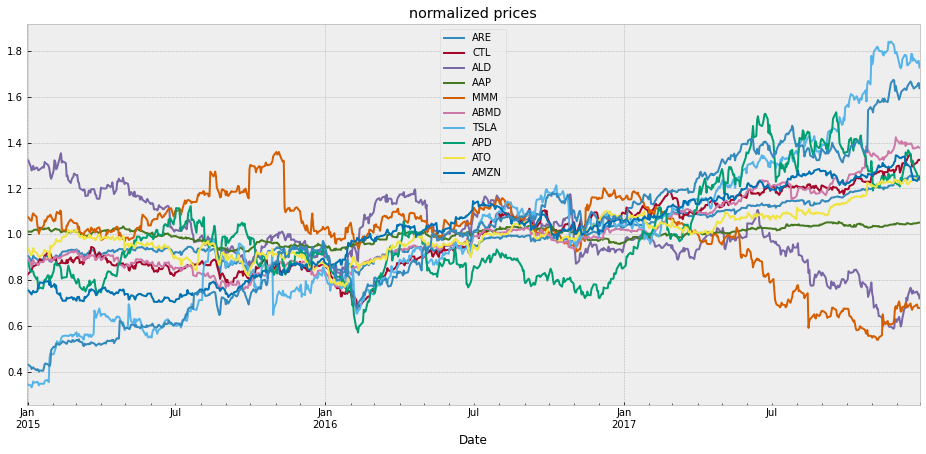

In [21]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for _, data in rp_df.iteritems():
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

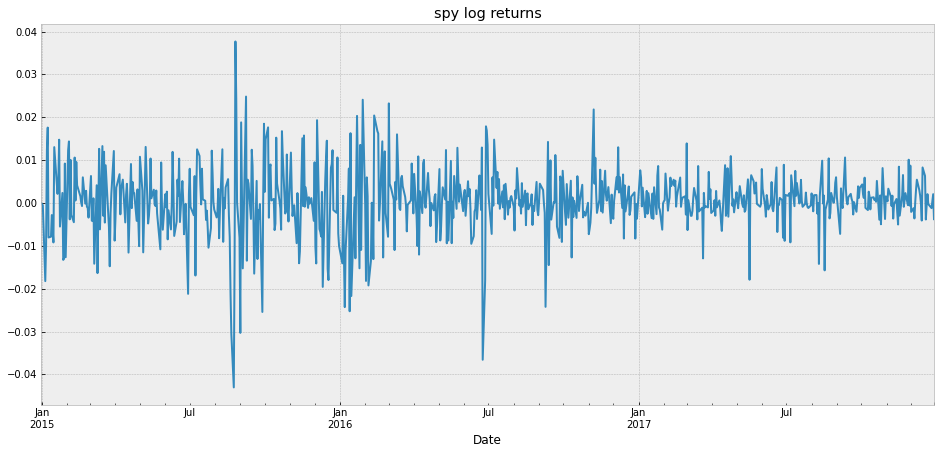

In [22]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

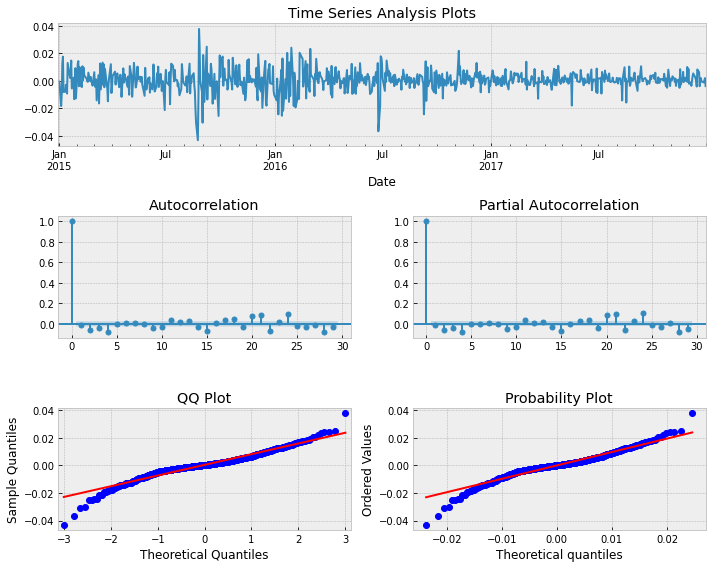

In [23]:
tsplot(spy)

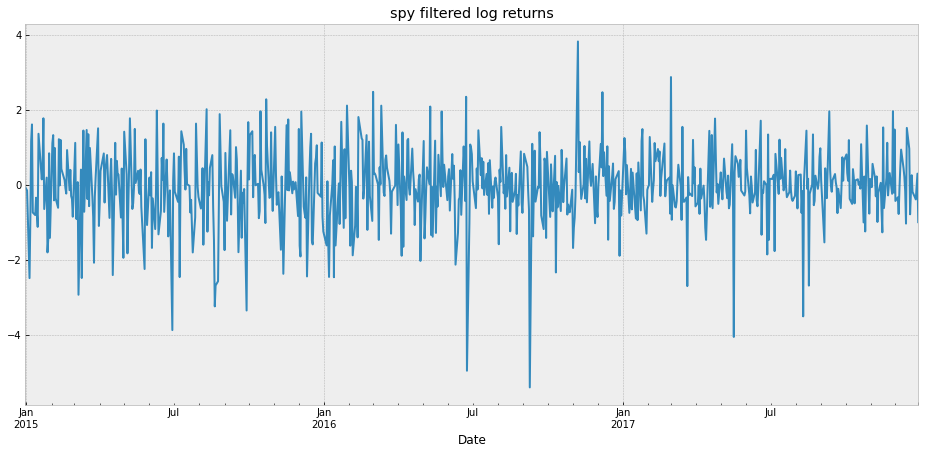

In [24]:
spyf, spy_means, spy_vars = arch_filtered_series(spy, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                p=p_, o=o_, q=q_)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

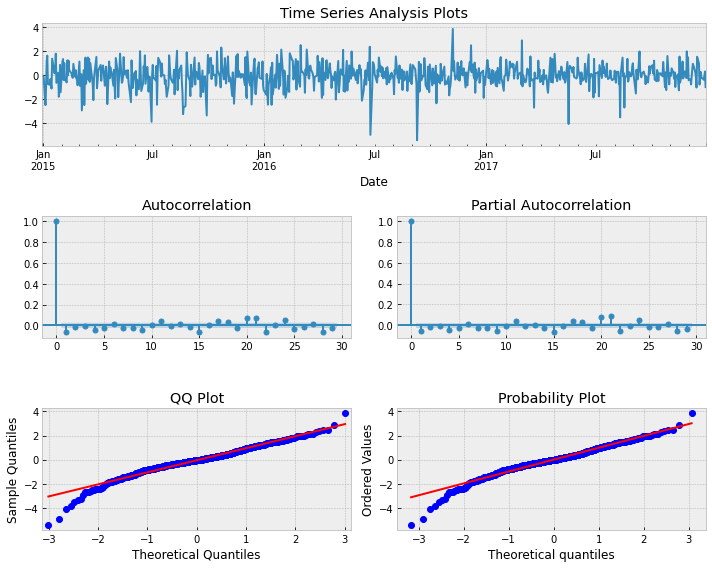

In [25]:
tsplot(spyf)

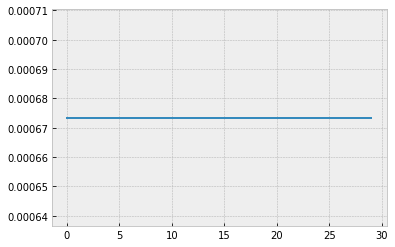

In [26]:
spy_means.plot()
plt.show()

In [27]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.354182
p-value: 0.979698
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -15.920028
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -29.103844
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [28]:
mkt_returns = {}
for ticker, data in rp_df.iteritems():
    mkt_returns[ticker] = raw_adj_close_log_returns(data)

In [29]:
# %%time
# aic, params = _find_best_model_params(spy)

In [30]:
# for ticker in tickers:
#    aic, params = _find_best_model_params(mkt_returns[ticker])

In [31]:
%%time
betas = {}
if BETA_TYPE == BetaType.NO:
    for ticker in tickers:
        betas[ticker] = 0
elif BETA_TYPE == BetaType.RAW:
    for ticker, data in raw_prices.items():
        betas[ticker] = beta(spy_p, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.RETURNS:
    for ticker, data in mkt_returns.items():
        betas[ticker] = beta(spy, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.FILTERED:
    filtered_returns = {}
    for ticker, net_rets in mkt_returns.items():
        fltr_res, _, _ = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_, 
                                              p=p_, o=o_, q=q_)
        filtered_returns[ticker] = fltr_res[GARCH_LAG:]
    for ticker, data in filtered_returns.items():
        betas[ticker] = beta(spyf, data, lag=BETA_LAG)
betas

CPU times: user 3.64 s, sys: 3.21 s, total: 6.85 s
Wall time: 1.19 s


{'ARE': 0.24903428423033472,
 'CTL': 0.2189802418536012,
 'ALD': 0.10694757444173933,
 'AAP': 0.1932219143003419,
 'MMM': 0.3395153949396362,
 'ABMD': 0.2597424268366333,
 'TSLA': 0.22060040545568396,
 'APD': 0.3708309990641236,
 'ATO': 0.21960508209773563,
 'AMZN': 0.2950625125524241}

In [32]:
net_market_returns = {}
for ticker, data in mkt_returns.items():
    net_market_returns[ticker] = data - spy * betas[ticker]
    
nmkt_rets_df = pd.DataFrame(net_market_returns, columns=tickers)
nmkt_rets_df



,ARE,CTL,ALD,AAP,MMM,ABMD,TSLA,APD,ATO,AMZN
Date,,,,,,,,,,
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-02,0.011896,0.000370,-0.003572,-0.004427,-0.001402,-0.019763,-0.013918,0.008484,0.002984,-0.005756
2015-01-05,0.016495,-0.017455,0.002590,-0.009747,-0.016623,-0.001720,-0.038930,-0.025738,-0.014231,-0.015353
2015-01-06,0.007406,-0.010392,0.000157,0.001125,-0.007508,-0.023226,0.007736,0.003154,-0.004135,-0.020306
2015-01-07,0.010402,0.002501,0.002092,0.018868,0.003018,0.028117,-0.004295,0.006151,0.011478,0.006890
...,...,...,...,...,...,...,...,...,...,...
2017-12-22,0.004944,-0.013196,0.000028,0.004236,-0.000124,0.005352,-0.019612,0.001689,0.002764,-0.005386
2017-12-26,0.007456,0.007199,0.001116,0.014157,0.003469,-0.010708,-0.024360,-0.002130,-0.005513,0.007517
2017-12-27,0.006300,-0.016953,0.001701,-0.021807,0.003015,0.004506,-0.018075,0.003922,0.004492,0.004519


In [33]:
%%time
today = 2 * GARCH_LAG + 1
nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[(today - 2 * GARCH_LAG - 1): today])#fixme check

CPU times: user 3.01 s, sys: 2.75 s, total: 5.76 s
Wall time: 1.01 s


In [34]:
corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)

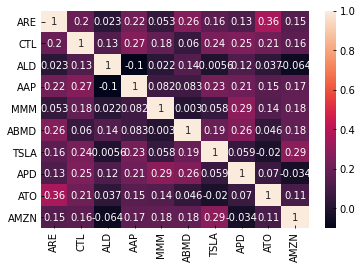

In [35]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [36]:
def trade(alphas, positions, prices, i):
    new_positions = pd.DataFrame({}, columns=tickers, index=[0])
    cash = positions.iloc[0]['CASH']
    if cash < 0:
        print("Negative cash! Bankrupt! ", cash, " @ ", i)
        print(alphas)
        print('=======================================================')
        print(positions)
        print('=======================================================')
        print(prices)
    pv_ = cash
    for ticker in tickers:
        pv_ = pv_ + positions.iloc[0][ticker] * prices[ticker]
    expected_positions = alphas.iloc[0] * pv_
    max_pos = pv_ * MAX_POSITION_PER_EQUITY
    max_trade = pv_ * MAX_POSITION_PER_EQUITY_PER_TRADE
    for ticker in tickers:
        expected_positions[ticker] = min(expected_positions[ticker], max_pos)
    for ticker in tickers:
        amount_to_buy = expected_positions[ticker] - positions.iloc[0][ticker] * prices[ticker]
        if abs(amount_to_buy) > max_trade:
            amount_to_buy = math.copysign(max_trade, amount_to_buy)
        cash = cash - amount_to_buy - abs(amount_to_buy) * FEE
        new_positions[ticker] = positions.iloc[0][ticker] + amount_to_buy / prices[ticker]
    new_positions['CASH'] = cash    
    return pv_, new_positions
    

In [37]:
%%time
init_positions = {}
for ticker in tickers:
    init_positions[ticker] = 0
init_positions['CASH'] = INITIAL_CASH
positions = pd.DataFrame(init_positions, index=[0])

pv_series = [INITIAL_CASH]
last_refit_date = GARCH_LAG * 2 + 1
while last_refit_date < len(rp_df):
    nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[: last_refit_date])#fixme check
    corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)
    for offset in range(0, GARCH_REFIT_DELAY_DAYS):
        today = min(last_refit_date + offset + 1, len(nmkt_rets_df) - 1)
        alphas = calc_alphas(nmkt_rets_df.iloc[today], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
        alphas_array = alphas.to_numpy()
        # alpha_norma = max(max(alphas_array[0]), -min(alphas_array[0]))
        alpha_norma = alphas_array[0].sum()
        normalized_alphas = alphas / alpha_norma # / 100 * MAX_POSITION_PER_EQUITY
        pv, new_positions = trade(normalized_alphas, positions.tail(1), rp_df.iloc[today], today)
        pv_series.append(pv)
        positions = positions.append(new_positions, ignore_index=True)
    last_refit_date = last_refit_date + GARCH_REFIT_DELAY_DAYS

CPU times: user 1min 8s, sys: 1min 2s, total: 2min 11s
Wall time: 20.5 s


In [38]:
positions

,ARE,CTL,ALD,AAP,MMM,ABMD,TSLA,APD,ATO,AMZN,CASH
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500000.000000
1,503.649104,-2538.966251,1149.025158,297.406596,316.676046,-415.800416,-1086.814751,-37.921207,-702.484109,65.275857,454227.896501
2,3.412054,-5043.724288,978.031817,597.568490,0.102142,-831.455403,18.302675,368.113323,4.336765,130.418153,411264.567075
3,-490.674131,-2546.467774,57.815388,604.475082,110.497520,-429.095931,-1064.790402,-34.047968,541.944831,65.830950,493634.671352
4,11.308234,-60.758234,-1076.487369,302.011707,-180.903859,-26.497373,36.579340,368.965679,-162.979565,1.158292,489510.233276
...,...,...,...,...,...,...,...,...,...,...,...
356,327.885729,6805.830154,-104.657452,-429.667468,217.961782,463.970679,-1594.247245,-586.477297,-542.358057,74.352270,367667.471752
357,352.211437,6804.325681,-108.161443,-870.562835,228.167729,463.868115,-2292.284216,-604.845288,-564.656771,74.335834,454199.917204
358,332.526057,6802.808082,-104.821873,-1311.359867,220.266574,463.764656,-2990.165502,-590.415207,-544.436660,74.319254,541161.165344
359,354.602824,6801.319654,-108.061577,-1617.498079,229.659930,463.663186,-3687.894094,-607.795266,-564.910308,74.302993,614539.114822


In [39]:
# positions.index = spy_p.index[-len(positions):]
# plt.figure(figsize=(20, 8))
# positions['AES'].plot()

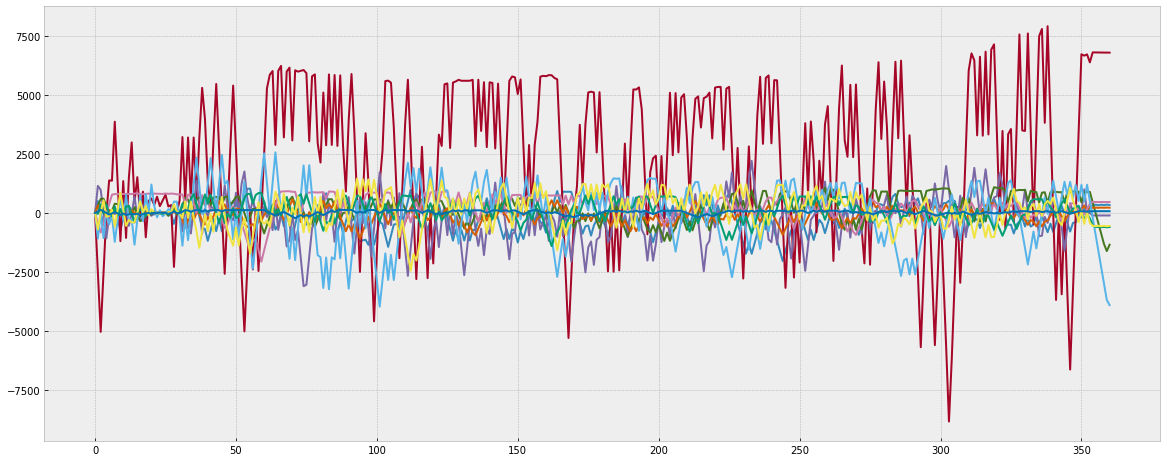

In [40]:
plt.figure(figsize=(20, 8))
for ticker in tickers:
    positions[ticker].plot()

<AxesSubplot:>

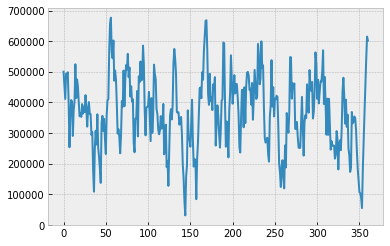

In [41]:
positions['CASH'].plot()

<AxesSubplot:xlabel='Date'>

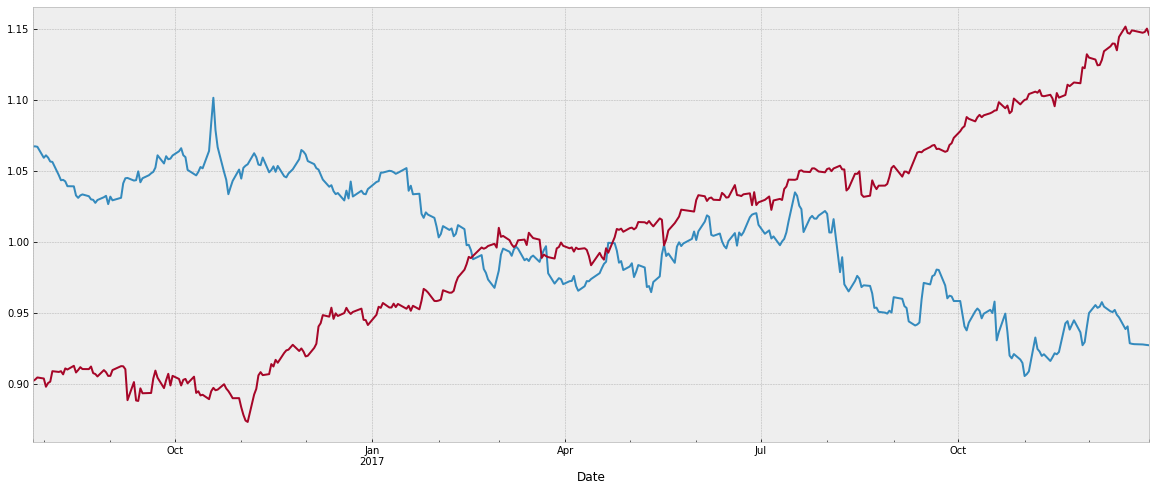

In [42]:
pv_s = pd.Series(pv_series)
pv_s.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20, 8))
(pv_s / pv_s.mean()).plot()
(spy_p[-len(positions):] / spy_p[-len(positions):].mean()).plot()
# (rp_df['ALD'][-len(positions):] / rp_df['ALD'][-len(positions):].mean()).plot()
# (rp_df['MMM'][-len(positions):] / rp_df['MMM'][-len(positions):].mean()).plot()

<AxesSubplot:xlabel='Date'>

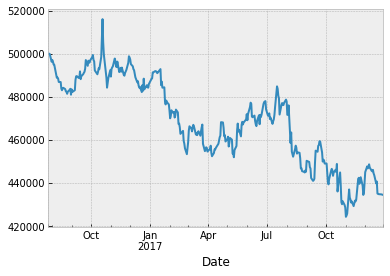

In [43]:
pv_s.plot()

In [44]:
pv_s[-1:]

Date
2017-12-29    434392.717304
Freq: D, dtype: float64

<AxesSubplot:xlabel='Date'>

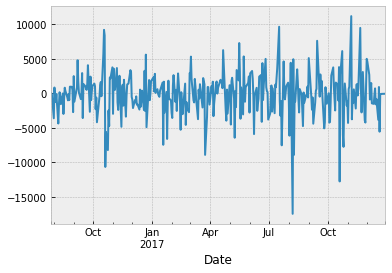

In [45]:
pnl = pv_s.diff()
pnl.plot()

In [46]:
pnl.min() / INITIAL_CASH

-0.03495814475284272

In [47]:
beta(spy[-len(pnl):], pnl)

-745.5440917765654

In [48]:
beta(spy_p[-len(pv_s):], pv_s)

-332.7688267414379

In [49]:
pnl.mean() / pnl.std()

-0.0577660270203516